In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import date

def fetch_data(symbol, start_date, end_date=date.today()):
    return yf.download(symbol, start=start_date, end=end_date)

def calculate_moving_averages(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    alpha_50 = 2 / (50 + 1)
    alpha_200 = 2 / (200 + 1)
    data['50_day_EMA'] = data['Close'].ewm(alpha=alpha_50, adjust=False).mean()
    data['200_day_EMA'] = data['Close'].ewm(alpha=alpha_200, adjust=False).mean()
    return data

def calculate_returns_and_signals(data):
    data['Daily_Return'] = data['Close'].pct_change()
    data['Signal'] = np.where(data['SMA_200'] < data['SMA_50'], 1, 0)
    data['Strategy_Return'] = data['Daily_Return'] * data['Signal'].shift(1)
    data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()
    return data

def plot_moving_averages(data):
    plt.figure(dpi=150)
    plt.plot(data.index, data['50_day_EMA'], label='50 Day EMA')
    plt.plot(data.index, data['200_day_EMA'], label='200 Day EMA')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Exponential Moving Averages for ' + symbol)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def plot_support_and_resistance(data):
    rolling_window = 10
    data['Rolling High'] = data['High'].rolling(window=rolling_window).max()
    data['Rolling Low'] = data['Low'].rolling(window=rolling_window).min()

    price_bins = 100
    bin_prices = np.linspace(data['Low'].min(), data['High'].max(), price_bins)
    data['Price Bin'] = pd.cut(data['Close'], bins=bin_prices)
    volume_profile = data.groupby('Price Bin')['Volume'].sum()
    major_volume_levels = volume_profile.nlargest(5).index.to_list()

    ap = [
        mpf.make_addplot(data['Rolling High'], color='r'),
        mpf.make_addplot(data['Rolling Low'], color='g')
    ]
    
    for level in major_volume_levels:
        ap.append(mpf.make_addplot([level.mid] * len(data), color='b', linestyle='solid'))

    mpf.plot(data, type='candle', style='charles', title='Stock Price with Support and Resistance', ylabel='Price', addplot=ap, volume=False)


[*********************100%***********************]  1 of 1 completed


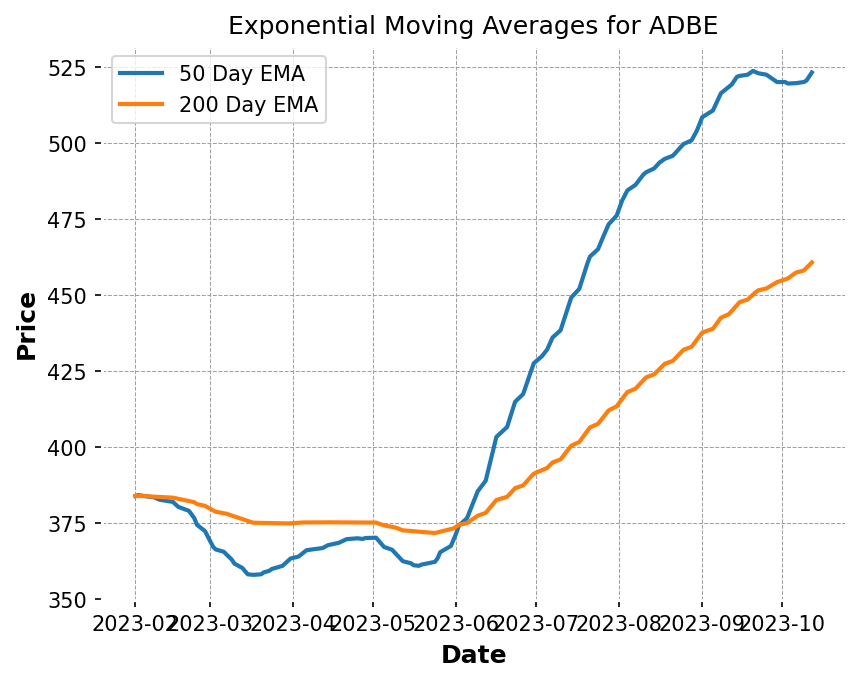

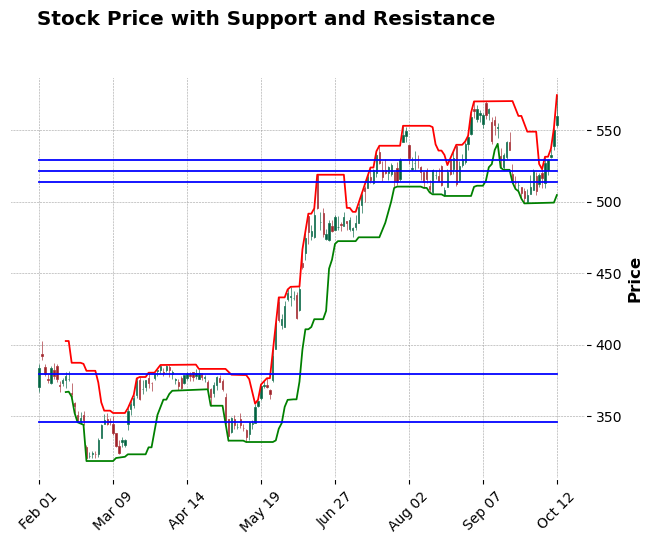

In [7]:
if __name__ == "__main__":
    symbol = 'ADBE'
    start_date = '2023-02-01'
    end_date = date.today()
    data = fetch_data(symbol, start_date, end_date)
    data = calculate_moving_averages(data)
    data = calculate_returns_and_signals(data)
    plot_moving_averages(data)
    plot_support_and_resistance(data)
